## Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
x1 = torch.arange(0.01, 4.01, 0.01)
x1.shape

torch.Size([400])

In [3]:
x1 = torch.cat([x1, -x1])
x1.shape

torch.Size([800])

In [4]:
x2_plus = torch.pow(x1, -1)
x2_plus.shape

torch.Size([800])

In [5]:
x2_minus = -x2_plus
x2_minus.shape

torch.Size([800])

In [6]:
X_plus = torch.cat([x1.unsqueeze(1), x2_plus.unsqueeze(1)], 1)
X_plus.shape

torch.Size([800, 2])

In [7]:
X_minus = torch.cat([x1.unsqueeze(1), x2_minus.unsqueeze(1)], 1)
X_minus.shape

torch.Size([800, 2])

In [8]:
Y_plus = torch.ones((800, 1))
Y_plus.shape

torch.Size([800, 1])

In [9]:
Y_minus = torch.zeros((800, 1))
Y_minus.shape

torch.Size([800, 1])

In [10]:
X = torch.cat([X_plus, X_minus])
Y = torch.cat([Y_plus, Y_minus])

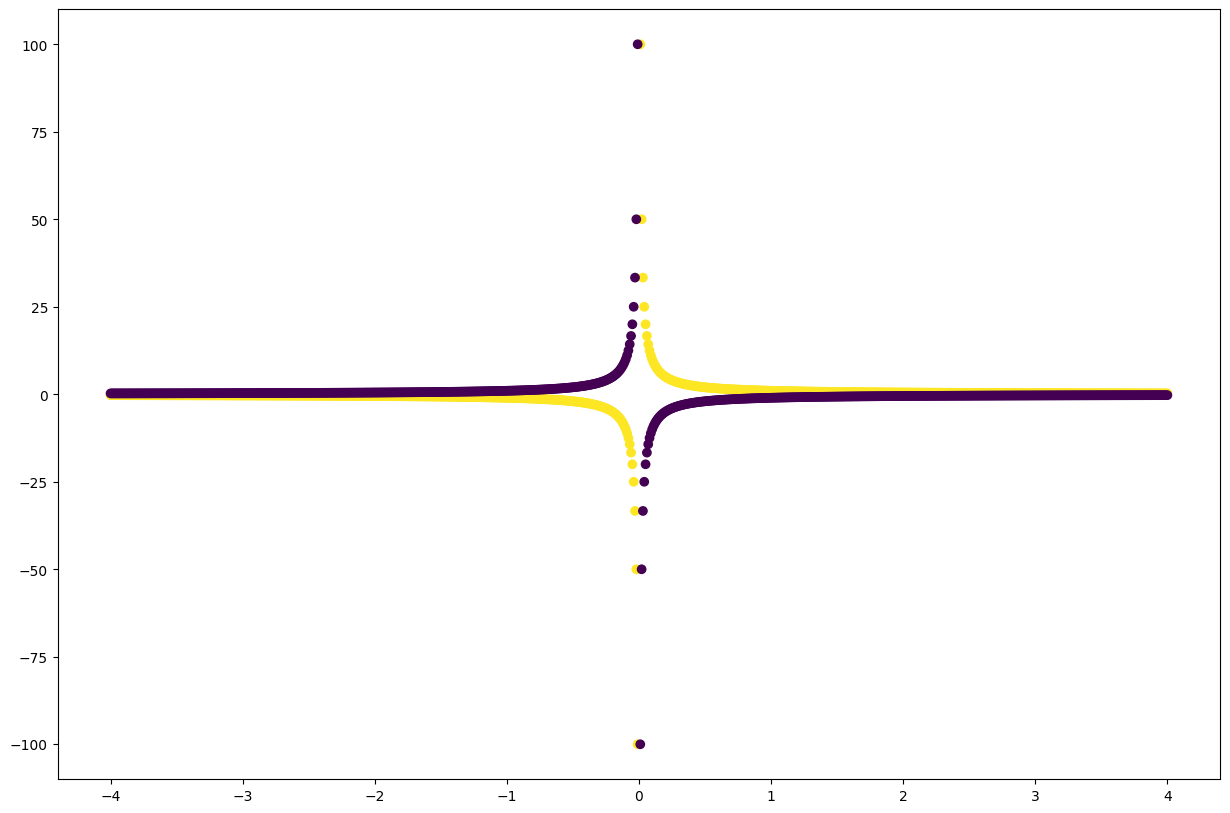

In [11]:
plt.figure(figsize=(15, 10))
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.1)
X_training.shape, X_test.shape, Y_training.shape, Y_test.shape

(torch.Size([1440, 2]),
 torch.Size([160, 2]),
 torch.Size([1440, 1]),
 torch.Size([160, 1]))

In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(X_training, Y_training, test_size=1/9)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([1280, 2]),
 torch.Size([160, 2]),
 torch.Size([1280, 1]),
 torch.Size([160, 1]))

## SVM

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [16]:
def dim_prod_kernel(U, V):
    K = torch.zeros((U.shape[0], V.shape[0]))
    for i, u in enumerate(U):
        for j, v in enumerate(V):
            K[i][j] = u[0]*u[1]*v[1]*v[0]
    return K

In [17]:
model = SVC(max_iter=1000, kernel=dim_prod_kernel)

In [18]:
model.fit(X_train, Y_train.squeeze())

SVC(kernel=<function dim_prod_kernel at 0x7f31fe4fe680>, max_iter=1000)

In [19]:
preds_train, preds_val = model.predict(X_train), model.predict(X_val)
score_train, score_val = accuracy_score(Y_train.squeeze(), preds_train), accuracy_score(Y_val.squeeze(), preds_val)
score_train, score_val

(1.0, 1.0)

## ANN

In [20]:
device = 'cpu'

In [21]:
import torch
from torch import nn

In [22]:
class SimpleNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

In [23]:
from scripts.utils import make_dataloader

train_dataloader = make_dataloader(X_train, Y_train, batch_size=32, shuffle=True)
val_dataloader = make_dataloader(X_val, Y_val, batch_size=32)

In [32]:
model = SimpleNN().to(device)

In [33]:
from scripts.metrics import BinaryAccuracy

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters())
metric = BinaryAccuracy()

In [34]:
from scripts.train import train_classifier

history = train_classifier(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=100,
    device=device
)

Training model for 100 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.687110, Train score: 0.560156, Val loss: 0.676344, Val score: 0.693750
Epoch: 2 => Train loss: 0.661490, Train score: 0.802344, Val loss: 0.642135, Val score: 0.912500
Epoch: 3 => Train loss: 0.622655, Train score: 0.942969, Val loss: 0.587105, Val score: 0.981250
Epoch: 4 => Train loss: 0.557083, Train score: 0.977344, Val loss: 0.505263, Val score: 0.987500
Epoch: 5 => Train loss: 0.468519, Train score: 0.988281, Val loss: 0.399421, Val score: 0.987500
Epoch: 6 => Train loss: 0.379565, Train score: 0.978906, Val loss: 0.306044, Val score: 0.987500
Epoch: 7 => Train loss: 0.297209, Train score: 0.987500, Val loss: 0.238980, Val score: 0.987500
Epoch: 8 => Train loss: 0.231465, Train score: 0.985156, Val loss: 0.188745, Val score: 0.987500
Epoch: 9 => Train loss: 0.197507, Train score: 0.981250, Val loss: 0.192441, Val score: 0.968750
Epoch: 10 => Train loss: 0.166953, Train score: 0.983594, Val loss: 0.13

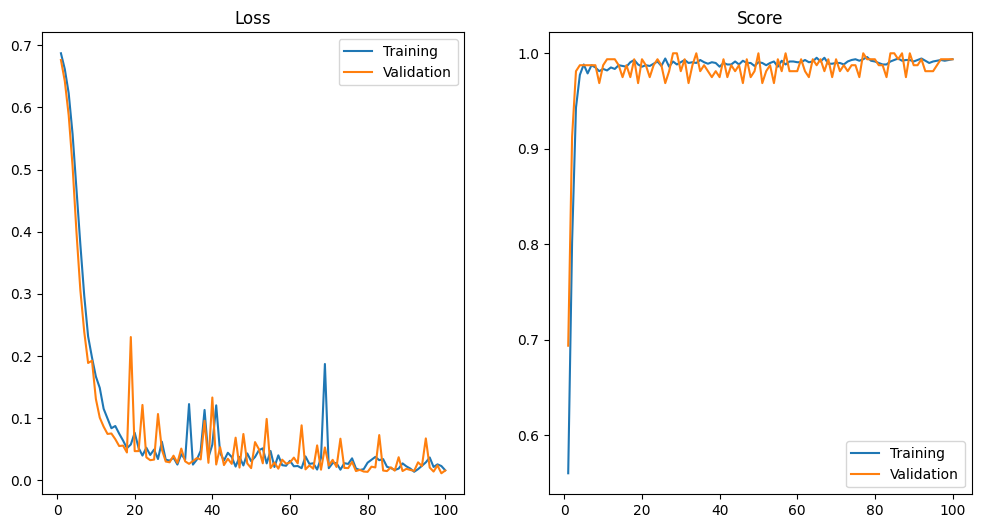

In [35]:
from scripts.utils import plot_train_history

plot_train_history(history)